GitHub Repository: https://github.com/Boukhsibiali19/HAH913-ENMO-BoukhsibiAli.git

Team Members: Ali Boukhsibi (Individual)

Date: October 5th 2025



This script begins by loading essential Python libraries such as pandas, numpy, and matplotlib for data processing and visualization. It then locates and reads the accelerometer dataset (0_z.csv), skipping any commented lines that start with #.

After importing the data, the script standardizes the column names and converts the key variables (t, x, y, z) into numeric types, automatically replacing any invalid entries with missing values.

It proceeds to remove incomplete rows, sorts the dataset according to the time variable, and resets the index for a clean structure.

In the end, the script prints out the first few rows of the refined DataFrame to ensure that the data has been correctly imported and is ready for subsequent analysis.

 We start by reading the data. The file `0_z.csv` is imported, which contains the time column (`t`, in seconds) and the three acceleration components (`x`, `y`, `z`, in g).


In [1]:
import pandas as pd

We read the file, ignoring the first comment line: accelerometer data in g, and we display the 5 rows and column names to verify the file and structure 


In [2]:
df = pd.read_csv(r"C:\Users\alibo\Downloads\0_z.csv", comment="#")
print(df.head())
print(df.columns)

      t       x       y       z
0  0.00 -0.0938 -0.0156  0.9531
1  0.02 -0.0938 -0.0156  0.9531
2  0.04 -0.0938 -0.0156  0.9531
3  0.06 -0.0938 -0.0156  0.9531
4  0.08 -0.0938 -0.0156  0.9531
Index(['t', 'x', 'y', 'z'], dtype='object')


## ENMO Calculation
Next, we calculate ENMO and check the first 5 rows. I asked Copilot to provide the code to compute ENMO.

In [5]:
import numpy as np

r = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
df["enmo"] = np.maximum(0, r - 1)

print(df.head())


      t       x       y       z  enmo
0  0.00 -0.0938 -0.0156  0.9531   0.0
1  0.02 -0.0938 -0.0156  0.9531   0.0
2  0.04 -0.0938 -0.0156  0.9531   0.0
3  0.06 -0.0938 -0.0156  0.9531   0.0
4  0.08 -0.0938 -0.0156  0.9531   0.0


## Grouping Data into Epochs

We group the data into fixed windows (epochs) of 10 s, 30 s, and 60 s. I asked Copilot to re-explain epochs with an example and provide the simplest code.

We need a time index to group data by fixed windows.

In [6]:
# Convert t (seconds) to datetime format
df["time"] = pd.to_datetime(df["t"], unit="s")

# Set this column as the dataframe index
df = df.set_index("time")

# Calculate mean ENMO for 10, 30, and 60-second windows using pandas resample()
enmo_10s = df["enmo"].resample("10s").mean()
enmo_30s = df["enmo"].resample("30s").mean()
enmo_60s = df["enmo"].resample("60s").mean()

# Verify first 5 rows
print(enmo_10s.head())
print(enmo_30s.head())
print(enmo_60s.head())


time
1970-01-01 00:00:00    0.00004
1970-01-01 00:00:10    0.00000
1970-01-01 00:00:20    0.00000
1970-01-01 00:00:30    0.00000
1970-01-01 00:00:40    0.00000
Freq: 10s, Name: enmo, dtype: float64
time
1970-01-01 00:00:00    0.000013
1970-01-01 00:00:30    0.000117
1970-01-01 00:01:00    0.000000
1970-01-01 00:01:30    0.000000
1970-01-01 00:02:00    0.000000
Freq: 30s, Name: enmo, dtype: float64
time
1970-01-01 00:00:00    0.000065
1970-01-01 00:01:00    0.000000
1970-01-01 00:02:00    0.000133
1970-01-01 00:03:00    0.000093
1970-01-01 00:04:00    0.358817
Freq: 60s, Name: enmo, dtype: float64


## Visualization: Mean ENMO vs Integrated ENMO

We produce two complementary views for each epoch (10 s, 30 s, 60 s):

Mean ENMO per epoch:
Calculation: average ENMO within the window
Why? Smooths the signal and gives the average activity intensity over a standardized time step. Useful for comparing periods and seeing general trends.

Integrated ENMO per epoch:
Calculation: sum of ENMO × Δt within the window (→ g·min)
Why? Measures total accumulated activity during the epoch (area under the curve). Useful to quantify total “effort” even if instantaneous intensity varies.

We save the plots under the requested names:

enmo_plot_10.0s.png

enmo_plot_30.0s.png

enmo_plot_60.0s.png

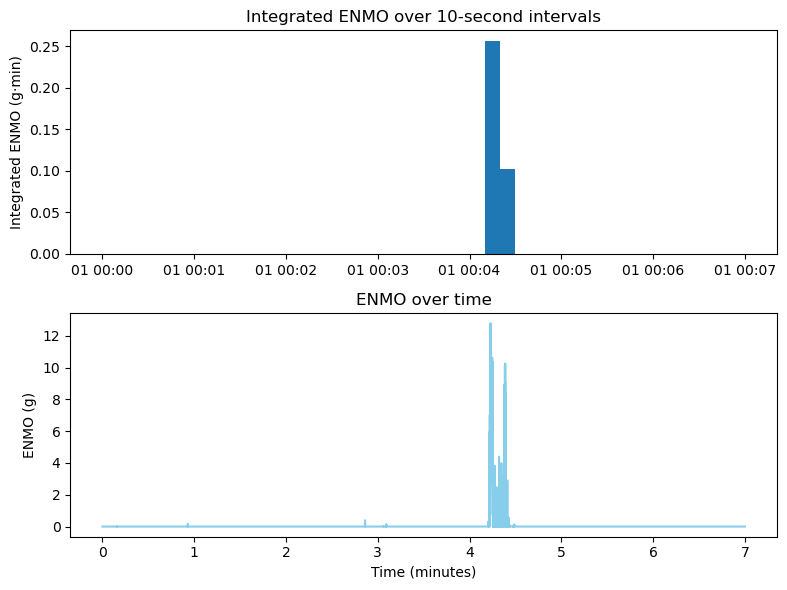

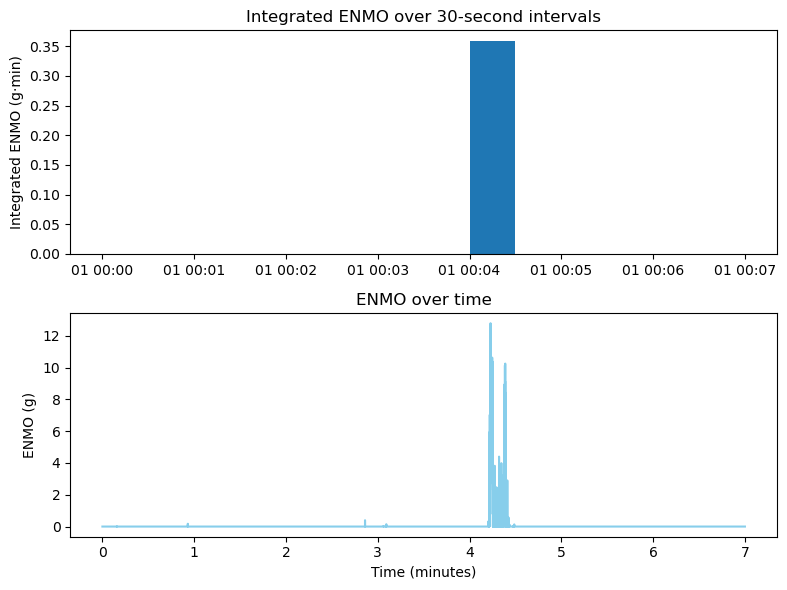

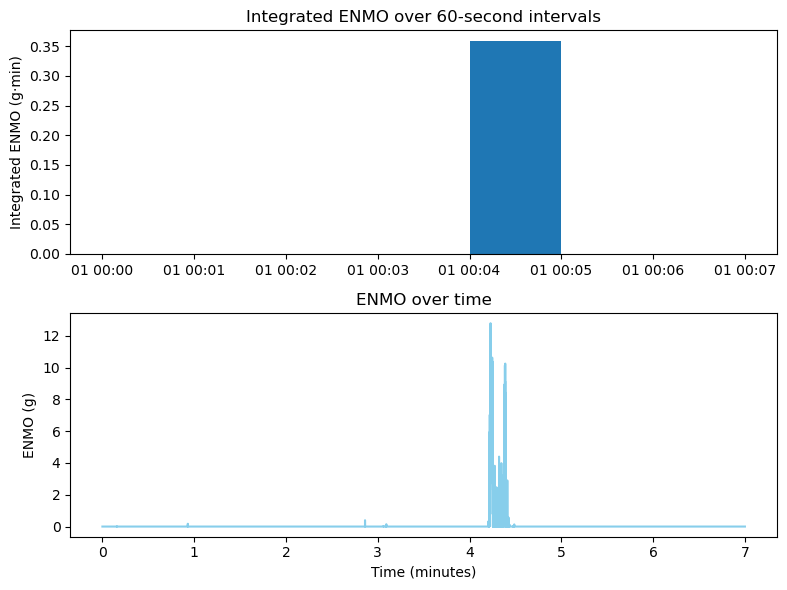

In [7]:
import matplotlib.pyplot as plt

# Loop over the three epoch lengths
for ep in [10, 30, 60]:
    # Time step between measurements (seconds)
    dt = df["t"].diff().fillna(0.0)

    # Integrated ENMO = sum of ENMO*dt per ep-second window (converted to g·min)
    enmo_integrated = (df["enmo"] * dt).resample(f"{ep}s").sum() / 60.0

    # Instantaneous ENMO time in minutes
    minutes = (df.index - df.index[0]).total_seconds() / 60.0

    # Create two plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))

    # Top: Integrated ENMO per window
    width_days = ep / 86400.0   # bar width (in days for matplotlib)
    ax1.bar(enmo_integrated.index, enmo_integrated.values, width=width_days, align="edge")
    ax1.set_title(f"Integrated ENMO over {ep}-second intervals")
    ax1.set_ylabel("Integrated ENMO (g·min)")

    # Bottom: Instantaneous ENMO over time
    ax2.plot(minutes, df["enmo"], color="skyblue")
    ax2.set_title("ENMO over time")
    ax2.set_xlabel("Time (minutes)")
    ax2.set_ylabel("ENMO (g)")

    # Save and show
    plt.tight_layout()
    plt.savefig(f"enmo_plot_{ep}.png", dpi=150)
    plt.show()


Interpretation

The peaks in ENMO(t) correspond to sudden or rapid movements.

- With 10-second epochs, bursts of activity can be finely localized.

- With 30- to 60-second epochs, the activity load is smoothed, making it easier to compare longer periods.

> The total integral (sum of all bars) remains consistent regardless of epoch length.

Conclusion

The choice of epoch length depends on the objective:

- Short epochs are suited for analyzing the fine dynamics of movement,

- While longer epochs provide a more global overview of activity.